In [1]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python Docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

# Input data files are available in the read-only "../input/" directory
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
#         print(os.path.join(dirname, filename))

# You can write up to 20GB to the current directory (/kaggle/working/) that gets preserved as output when you create a version using "Save & Run All" 
# You can also write temporary files to /kaggle/temp/, but they won't be saved outside of the current session

SyntaxError: incomplete input (3781909007.py, line 17)

In [1]:
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline
np.random.seed(2)
from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix
from keras.utils.np_utils import to_categorical
from keras.models import Sequential
from keras.layers import Dense, Flatten, Conv2D, MaxPool2D, Dropout
from keras.optimizers import Adam
from keras.preprocessing.image import ImageDataGenerator
from keras.callbacks import EarlyStopping

/opt/conda/lib/python3.10/site-packages/tensorflow_io/python/ops/__init__.py:98: UserWarning: unable to load libtensorflow_io_plugins.so: unable to open file: libtensorflow_io_plugins.so, from paths: ['/opt/conda/lib/python3.10/site-packages/tensorflow_io/python/ops/libtensorflow_io_plugins.so']
caused by: ['/opt/conda/lib/python3.10/site-packages/tensorflow_io/python/ops/libtensorflow_io_plugins.so: undefined symbol: _ZN3tsl6StatusC1EN10tensorflow5error4CodeESt17basic_string_viewIcSt11char_traitsIcEENS_14SourceLocationE']
  warnings.warn(f"unable to load libtensorflow_io_plugins.so: {e}")
/opt/conda/lib/python3.10/site-packages/tensorflow_io/python/ops/__init__.py:104: UserWarning: file system plugins are not loaded: unable to open file: libtensorflow_io.so, from paths: ['/opt/conda/lib/python3.10/site-packages/tensorflow_io/python/ops/libtensorflow_io.so']
caused by: ['/opt/conda/lib/python3.10/site-packages/tensorflow_io/python/ops/libtensorflow_io.so: undefined symbol: _ZTVN10tenso

In [2]:
from PIL import Image, ImageChops, ImageEnhance
import os
import itertools

In [3]:
def convert_to_ela_image(path, quality):
    temp_filename = 'temp_file_name.jpg'
    ela_filename = 'temp_ela.png'
    
    image = Image.open(path).convert('RGB')
    image.save(temp_filename, 'JPEG', quality = quality)
    temp_image = Image.open(temp_filename)
    
    ela_image = ImageChops.difference(image, temp_image)
    
    extrema = ela_image.getextrema()
    max_diff = max([ex[1] for ex in extrema])
    if max_diff == 0:
        max_diff = 1
    scale = 255.0 / max_diff
    
    ela_image = ImageEnhance.Brightness(ela_image).enhance(scale)
    
    return ela_image

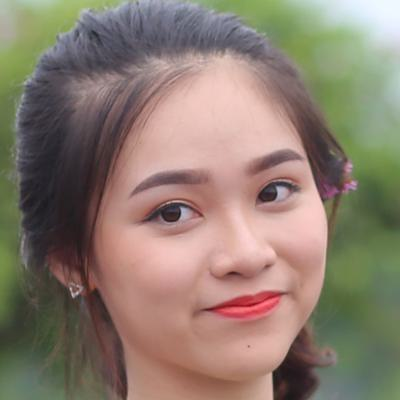

In [4]:
# real_image_path = '/kaggle/input/real-and-fake-face-detection-size-400x400/training_real/real_00140.jpg'
# real_image_path = '/kaggle/input/real-and-fake-face-detection-size-400x400/training_real/real_00229.jpg'
real_image_path = '/kaggle/input/real-image/real_00331.jpg'

Image.open(real_image_path)

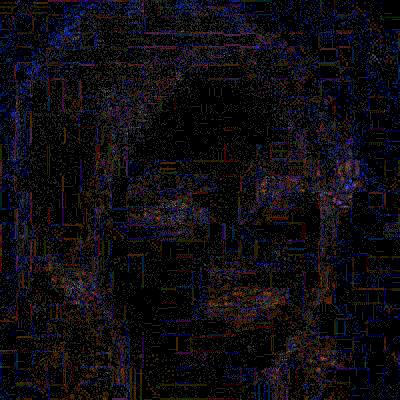

In [5]:
convert_to_ela_image(real_image_path, 90)

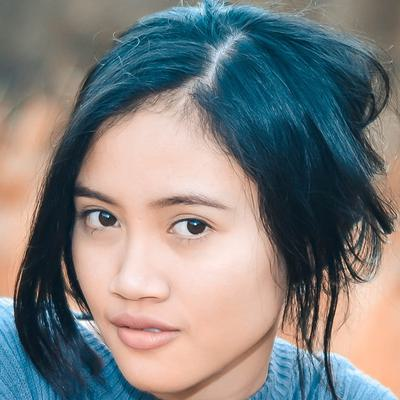

In [6]:
fake_image_path = '/kaggle/input/fake-image/hard_192_1111.jpg'
Image.open(fake_image_path)

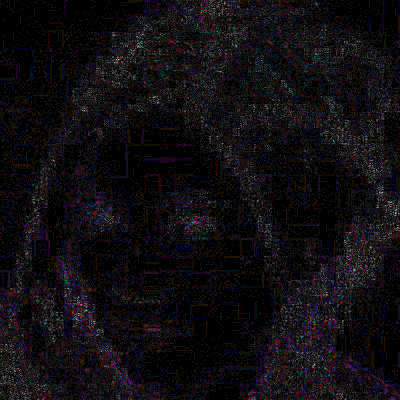

In [7]:
convert_to_ela_image(fake_image_path, 90)

In [8]:
image_size = (400, 400)

In [9]:
def prepare_image(image_path):
    return np.array(convert_to_ela_image(image_path, 90).resize(image_size)).flatten() / 255.0

In [10]:
X = [] # ELA converted images
Y = [] # 0 for fake, 1 for real

In [11]:
import random
path = '/kaggle/input/real-image'
for dirname, _, filenames in os.walk(path):
    for filename in filenames:
        if filename.endswith('jpg') or filename.endswith('png'):
            full_path = os.path.join(dirname, filename)
            X.append(prepare_image(full_path))
            Y.append(1)
            if len(Y) % 50 == 0:
                print(f'Processing {len(Y)} images')

random.shuffle(X)
X = X[:600]
Y = Y[:600]
print(len(X), len(Y))

Processing 50 images
Processing 100 images
Processing 150 images
Processing 200 images
Processing 250 images
Processing 300 images
Processing 350 images
Processing 400 images
Processing 450 images
Processing 500 images
Processing 550 images
Processing 600 images
600 600


In [12]:
path = '/kaggle/input/fake-image'
for dirname, _, filenames in os.walk(path):
    for filename in filenames:
        if filename.endswith('jpg') or filename.endswith('png'):
            full_path = os.path.join(dirname, filename)
            X.append(prepare_image(full_path))
            Y.append(0)
            if len(Y) % 50 == 0:
                print(f'Processing {len(Y)} images')
# X = X[:1200]
# Y = Y[:1200]
print(len(X), len(Y))

Processing 650 images
Processing 700 images
Processing 750 images
Processing 800 images
Processing 850 images
Processing 900 images
Processing 950 images
Processing 1000 images
Processing 1050 images
Processing 1100 images
Processing 1150 images
Processing 1200 images
1200 1200


In [13]:
# len(X)

In [14]:
X = np.array(X)
Y = to_categorical(Y, 2)
X = X.reshape(-1, 400, 400, 3)

In [15]:
X.shape

(1200, 400, 400, 3)

In [16]:
X_train, X_val, Y_train, Y_val = train_test_split(X, Y, test_size = 0.2, random_state=5)
X = X.reshape(-1,1,1,1)
print(len(X_train), len(Y_train))
print(len(X_val), len(Y_val))

960 960
240 240


In [17]:
def build_model():
    model = Sequential()
    model.add(Conv2D(filters = 16, kernel_size = (5, 5), padding = 'valid', activation = 'relu', input_shape = (400, 400, 3)))
    model.add(Conv2D(filters = 16, kernel_size = (5, 5), padding = 'valid', activation = 'relu', input_shape = (400, 400, 3)))
    model.add(MaxPool2D(pool_size = (2, 2)))
    model.add(Dropout(0.25))
    model.add(Flatten())
    model.add(Dense(64, activation = 'relu'))
    model.add(Dropout(0.5))
    model.add(Dense(2, activation = 'softmax'))
    return model

In [18]:
model = build_model()
model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d (Conv2D)             (None, 396, 396, 16)      1216      
                                                                 
 conv2d_1 (Conv2D)           (None, 392, 392, 16)      6416      
                                                                 
 max_pooling2d (MaxPooling2D  (None, 196, 196, 16)     0         
 )                                                               
                                                                 
 dropout (Dropout)           (None, 196, 196, 16)      0         
                                                                 
 flatten (Flatten)           (None, 614656)            0         
                                                                 
 dense (Dense)               (None, 64)                39338048  
                                                        

In [23]:
epochs = 15
batch_size = 60

In [24]:
learning_rate = 1e-4
optimizer = Adam(learning_rate = learning_rate, decay = learning_rate/epochs)

In [25]:
model.compile(optimizer = optimizer, loss = 'binary_crossentropy', metrics = ['accuracy'])

In [26]:
early_stopping = EarlyStopping(monitor = 'val_acc',
                              min_delta = 0,
                              patience = 2,
                              verbose = 0,
                              mode = 'auto')

In [27]:
hist = model.fit(X_train,
                 Y_train,
                 batch_size = batch_size,
                 epochs = epochs,
                validation_data = (X_val, Y_val),
                callbacks = [early_stopping])

Epoch 1/15
16/16 [==============================] - 298s 19s/step - loss: 0.7517 - accuracy: 0.4844 - val_loss: 0.6939 - val_accuracy: 0.4958
Epoch 2/15
16/16 [==============================] - 293s 18s/step - loss: 0.6910 - accuracy: 0.5135 - val_loss: 0.6921 - val_accuracy: 0.4958
Epoch 3/15
16/16 [==============================] - 292s 18s/step - loss: 0.6875 - accuracy: 0.5292 - val_loss: 0.6879 - val_accuracy: 0.5542
Epoch 4/15
16/16 [==============================] - 292s 18s/step - loss: 0.6785 - accuracy: 0.5562 - val_loss: 0.6856 - val_accuracy: 0.5750
Epoch 5/15
16/16 [==============================] - 282s 18s/step - loss: 0.6673 - accuracy: 0.6000 - val_loss: 0.6811 - val_accuracy: 0.6083
Epoch 6/15
16/16 [==============================] - 269s 17s/step - loss: 0.6567 - accuracy: 0.5750 - val_loss: 0.6847 - val_accuracy: 0.5542
Epoch 7/15
16/16 [==============================] - 268s 17s/step - loss: 0.6468 - accuracy: 0.6042 - val_loss: 0.6834 - val_accuracy: 0.6000
Epoch 

**Evaluation**

In [28]:
# model.evaluate(X_val)
score = model.evaluate(X_val, Y_val, verbose = 0) 
print('Test loss:', score[0]) 
print('Test accuracy:', score[1])

Test loss: 0.6696648001670837
Test accuracy: 0.6041666865348816








**first way to save model:**

In [29]:
import tensorflow as tf
converter = tf.lite.TFLiteConverter.from_keras_model(model)
tfmodel = converter.convert()

open('model.tflite','wb').write(tfmodel)

157386476

**second way to save model**

In [23]:
import pickle
pickle.dump(model, open('model.pkl', 'wb'))

In [ ]:
pickled_model = pickle.load(open('model.pkl', 'rb'))
pickled_model.predict(X_val)

**third way to save model**

In [ ]:
model.save('model_fake_face.h5')

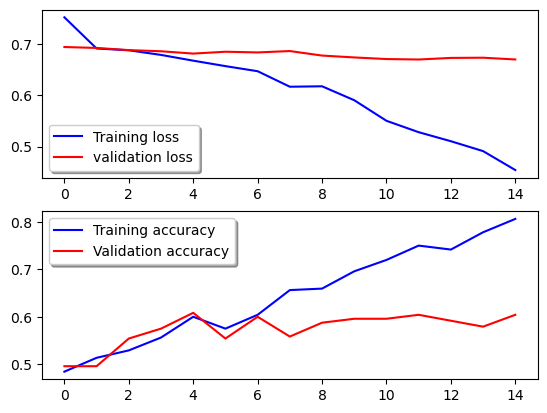

In [30]:
# Plot of loss and accuracy curves for training and validation 
fig, ax = plt.subplots(2,1)
ax[0].plot(hist.history['loss'], color='b', label="Training loss")
ax[0].plot(hist.history['val_loss'], color='r', label="validation loss",axes =ax[0])
legend = ax[0].legend(loc='best', shadow=True)

ax[1].plot(hist.history['accuracy'], color='b', label="Training accuracy")
ax[1].plot(hist.history['val_accuracy'], color='r',label="Validation accuracy")
legend = ax[1].legend(loc='best', shadow=True)

In [33]:
class_names = ['fake', 'real']

In [34]:
real_image = '/kaggle/input/real-image/real_00011.jpg'
image = prepare_image(real_image)
image = image.reshape(-1, 400, 400, 3)
y_pred = model.predict(image)
y_pred_class = np.argmax(y_pred, axis = 1)[0]
print(f'Class: {class_names[y_pred_class]} Confidence: {np.amax(y_pred) * 100:0.2f}')

1/1 [==============================] - 0s 95ms/step
Class: real Confidence: 88.23


In [35]:
fake_image = '/kaggle/input/fake-image/easy_120_0011.jpg'
image = prepare_image(fake_image)
image = image.reshape(-1, 400, 400, 3)
y_pred = model.predict(image)
y_pred_class = np.argmax(y_pred, axis = 1)[0]
print(f'Class: {class_names[y_pred_class]} Confidence: {np.amax(y_pred) * 100:0.2f}')

1/1 [==============================] - 0s 89ms/step
Class: fake Confidence: 82.25


In [42]:
fake_image = os.listdir('/kaggle/input/fake-image')
correct = 0
total = 0
for file_name in fake_image:
    if file_name.endswith('jpg') or filename.endswith('png'):
        fake_image_path = os.path.join('/kaggle/input/fake-image', file_name)
        image = prepare_image(fake_image_path)
        image = image.reshape(-1, 400, 400, 3)
        y_pred = model.predict(image)
        y_pred_class = np.argmax(y_pred, axis = 1)[0]
        total += 1
        if y_pred_class == 0:
            correct += 1
#             print(f'Class: {class_names[y_pred_class]} Confidence: {np.amax(y_pred) * 100:0.2f}')

1/1 [==============================] - 0s 85ms/step


In [43]:
print(f'Total: {total}, Correct: {correct}, Acc: {correct / total * 100.0}')

Total: 600, Correct: 527, Acc: 87.83333333333333


In [44]:
real_image = os.listdir('/kaggle/input/real-image')
correct_r = 0
total_r = 0
for file_name in real_image:
    if file_name.endswith('jpg') or filename.endswith('png'):
        real_image_path = os.path.join('/kaggle/input/real-image', file_name)
        image = prepare_image(real_image_path)
        image = image.reshape(-1, 400, 400, 3)
        y_pred = model.predict(image)
        y_pred_class = np.argmax(y_pred, axis = 1)[0]
        total_r += 1
        if y_pred_class == 1:
            correct_r += 1
            # print(f'Class: {class_names[y_pred_class]} Confidence: {np.amax(y_pred) * 100:0.2f}')

1/1 [==============================] - 0s 86ms/step


In [45]:
correct += correct_r
total += total_r
print(f'Total: {total_r}, Correct: {correct_r}, Acc: {correct_r / total_r * 100.0}')
print(f'Total: {total}, Correct: {correct}, Acc: {correct / total * 100.0}')

Total: 600, Correct: 563, Acc: 93.83333333333333
Total: 1200, Correct: 1090, Acc: 90.83333333333333
